In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.left'] = True

In [3]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [4]:
multivelo = anndata.read_h5ad(
    '../data/Mouse_brain/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Mouse_brain/celldancer.h5ad')

In [5]:
adata_out = anndata.read_h5ad(
    '../data/Mouse_brain/adata_out.moflow.mvstyle.h5ad')

In [6]:
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['c'] = multivelo.layers['Mc']
multivelo.layers['u'] = multivelo.layers['Mu']
multivelo.layers['s'] = multivelo.layers['Ms']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

In [7]:
adata_out.obs

,n_counts,initial_size_unspliced,initial_size_spliced,initial_size,celltype,velo_s_self_transition,root_cells,end_points,velo_s_pseudotime,celltype_new,velo_s_norm_self_transition,velo_s_norm_pseudotime,velo_s_pseudotime_categorical
AAACAGCCAACCGCCA-1,283.868958,4430,8428,8428.0,Upper Layer,0.146966,0.000008,0.497232,0.691744,Upper Layer,0.234371,0.739001,0.69
AAACAGCCAAGGTCGA-1,416.292938,4070,1367,1367.0,"RG, Astro, OPC",0.107063,0.814823,0.000103,0.062951,RG,0.156089,0.089590,0.06
AAACAGCCAGGAACAT-1,443.342316,9671,3792,3792.0,Deeper Layer,0.132777,0.009299,0.491547,0.886118,Deeper Layer,0.086667,0.907935,0.89
AAACAGCCATATTGAC-1,354.055695,6590,1585,1585.0,Deeper Layer,0.000000,0.010726,0.451035,0.963470,Deeper Layer,0.017148,0.977689,0.96
AAACAGCCATGGTTAT-1,320.253662,3865,4259,4259.0,Subplate,0.097970,0.001010,0.231199,0.687762,Subplate,0.166443,0.707401,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1,438.928192,14420,8118,8118.0,Ependymal cells,0.177877,0.003568,0.074634,0.713549,Subplate,0.188831,0.729733,0.71
TTTGTGGCATTTGCTC-1,337.838318,6241,3996,3996.0,Upper Layer,0.174872,0.000025,0.852618,0.721493,Upper Layer,0.267817,0.751517,0.72
TTTGTGTTCAATGACC-1,295.886993,4088,4446,4446.0,IPC,0.114999,0.009925,0.002797,0.247422,IPC,0.205810,0.253359,0.25
TTTGTTGGTGGAGCAA-1,432.463470,7554,3660,3660.0,Deeper Layer,0.157856,0.004118,0.469375,0.847500,Deeper Layer,0.172024,0.882758,0.85


In [8]:
labels = pd.read_csv('../temps/250325_mousebrain_cluster.csv', index_col=0)

In [9]:
from scipy.ndimage import uniform_filter1d

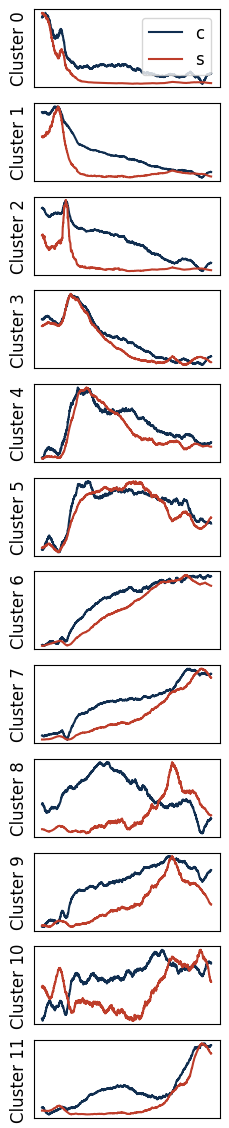

In [26]:
fig, axes = plt.subplots(12, 1, figsize=(2.4, 1.2*12))
for i in range(12):
    target = adata_out[:, labels[labels['label']==i].index].layers['Mc']
    target_ = target.mean(axis=1)
    target_ = target_[np.argsort(adata_out.obs['velo_s_norm_pseudotime'].ravel())]
    target_ = uniform_filter1d(target_, 100)
    target_ = target_ - target_.min()
    target_ = target_/target_.max()
    axes[i].plot(range(target_.shape[0]), target_, color='#102E50', label=['c'])
    
    target = adata_out[:, labels[labels['label']==i].index].layers['Ms']
    target_ = target.mean(axis=1)
    target_ = target_[np.argsort(adata_out.obs['velo_s_norm_pseudotime'].ravel())]
    target_ = uniform_filter1d(target_, 100)
    target_ = target_ - target_.min()
    target_ = target_/target_.max()
    axes[i].plot(range(target_.shape[0]), target_, color='#BE3D2A', label='s')
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel(f'Cluster {i}')
axes[0].legend()

fig.savefig('../figures/fig7A.pdf')

In [10]:

from fastdtw import fastdtw

In [11]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def smooth(x, size=3):# smoothing
    return uniform_filter1d(x, size=size)
def pad_ends(x):# Add zero to both ends
    return np.concatenate([[0], x, [0]])

def bin_and_average(x, time, n_bins=20):
    bins = np.linspace(np.min(time), np.max(time), n_bins + 1)
    binned = np.digitize(time, bins) - 1
    out = np.array([np.mean(x[binned == i]) for i in range(n_bins)])
    return out


def get_dtw(adata, gene, genetime=False, timekey = 'velo_s_pseudotime_', n_bins=20):
    #if genetime:
    #    adata_ = adata[np.argsort(adata[:, gene].layers[timekey].ravel())]
    #else:
    #    adata_ = adata[np.argsort(adata.obs[timekey])]
    #c = adata_[:, gene].layers['Mc'].ravel()
    #u = adata_[:, gene].layers['Mu'].ravel()
    #s = adata_[:, gene].layers['Ms'].ravel()
    
    if genetime:
        time = adata[:, gene].layers[timekey].ravel()
    else:
        time = adata.obs[timekey].values
    time = np.clip(time, 0, np.quantile(time, 0.95))

    c = adata[:, gene].layers['Mc'].ravel()
    u = adata[:, gene].layers['Mu'].ravel()
    s = adata[:, gene].layers['Ms'].ravel()
    
    c = bin_and_average(c, time, n_bins)
    u = bin_and_average(u, time, n_bins)
    s = bin_and_average(s, time, n_bins)


    c_norm = normalize(c)
    u_norm = normalize(u)
    s_norm = normalize(s)

    c_smooth = smooth(c_norm)
    u_smooth = smooth(u_norm)
    s_smooth = smooth(s_norm)

    c_pad = pad_ends(c_smooth)
    u_pad = pad_ends(u_smooth)
    s_pad = pad_ends(s_smooth)
    
    #print(c_pad.shape, s_pad.shape)
    #print(np.any(np.isnan(c_pad)), np.any(np.isinf(c_pad), np.any(np.isnan(s_pad)), np.any(np.isinf(s_pad))))
    #print(c_pad)
    time_pad = np.linspace(0, 1, len(c_pad))


    distance_c_s, path_c_s = fastdtw(c_pad, s_pad, )
    distance_u_s, path_u_s = fastdtw(u_pad, s_pad, )

    time_lag_c_s = [time_pad[j] - time_pad[i] for i, j in path_c_s]
    time_lag_u_s = [time_pad[j] - time_pad[i] for i, j in path_u_s]
    return(time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s)

def plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s, 
         axvspan='clusterbig', legend=['Astro', 'Oligo', 'Exc'],
         figsave=None):

    fig, axs = plt.subplots(2, 1, figsize=(4.8, 3.2), sharex=True)

    # Top: c vs s
    axs[0].plot(time_pad, c_pad, label='c', color='#102E50')
    axs[0].plot(time_pad, u_pad, label='u', color='#F5C45E')
    axs[0].plot(time_pad, s_pad, label='s', color='#BE3D2A')
    
    for i, j in path_c_s[::3]:  # skip some lines for clarity
        axs[0].plot([time_pad[i], time_pad[j]], [c_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    for i, j in path_u_s[::3]:
        axs[0].plot([time_pad[i], time_pad[j]], [u_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    
    axs[0].set_ylabel("Norm values")
    axs[0].legend()
    axs[0].set_title("DTW Alignment")

    # Middle: u vs s
    #axs[1].plot(time_pad, u_pad, label='u', color='#F5C45E')
    #axs[1].plot(time_pad, s_pad, label='s', color='#BE3D2A')
    #for i, j in path_u_s[::3]:
    #    axs[1].plot([time_pad[i], time_pad[j]], [u_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    #axs[1].set_ylabel("Norm values")
    #axs[1].legend()
    #axs[1].set_title("DTW Alignment: u vs s")

    # Bottom: time lag
    axs[1].plot([time_pad[i] for i, _ in path_c_s], time_lag_c_s, label='c-s lag', color='#3E3F5B')
    axs[1].plot([time_pad[i] for i, _ in path_u_s], time_lag_u_s, label='u-s lag', color='#8AB2A6')
    axs[1].axhline(0, color='gray', linestyle='--')
    axs[1].set_ylabel("Time lag")
    axs[1].set_xlabel("Time")
    axs[1].legend()
    #axs[2].set_title("Instantaneous Time Lags")
    
    fig.suptitle(gene)

    plt.tight_layout()
    plt.show()
    
    if figsave is not None:
        fig.savefig(figsave)
        




In [12]:
from scipy.interpolate import interp1d

def resample_timelag(timelag, n=22):
    x_old = np.linspace(0, 1, len(timelag))
    x_new = np.linspace(0, 1, n)
    f = interp1d(x_old, timelag, kind='linear', fill_value='extrapolate')
    return f(x_new)

In [13]:
nangene = []
time_lag_c_s_ = []
time_lag_u_s_ = []

c_pad_ = []
u_pad_ = []
s_pad_ = []

for g in adata_out.var_names:
    try:
        
        time_pad, c_pad, u_pad, s_pad, time_lag_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, g, timekey='velo_s_norm_pseudotime')
        time_lag_c_s_.append(resample_timelag(time_lag_c_s))
        time_lag_u_s_.append(resample_timelag(time_lag_u_s))
        
        c_pad_.append(c_pad)
        u_pad_.append(u_pad)
        s_pad_.append(s_pad)
        
    except:
        nangene.append(g)
    

In [14]:
indices_mf = np.setdiff1d(adata_out.var_names, np.array(nangene))


In [15]:
time_lag_c_s_mf = pd.DataFrame(time_lag_c_s_, index=indices_mf)
time_lag_u_s_mf = pd.DataFrame(time_lag_u_s_, index=indices_mf)

In [16]:
c_pad_mf = pd.DataFrame(c_pad_, index=indices_mf)
u_pad_mf = pd.DataFrame(u_pad_, index=indices_mf)
s_pad_mf = pd.DataFrame(s_pad_, index=indices_mf)
zero_pd_mf = (c_pad_mf>0.01)|(u_pad_mf>0.01)|(s_pad_mf>0.01)

In [17]:
time_lag_c_s_mf_ = time_lag_c_s_mf*zero_pd_mf
time_lag_u_s_mf_ = time_lag_u_s_mf*zero_pd_mf

In [18]:
nangene = []
time_lag_c_s_ = []
time_lag_u_s_ = []

c_pad_ = []
u_pad_ = []
s_pad_ = []
for g in adata_out.var_names:
    try:
        
        time_pad, c_pad, u_pad, s_pad, time_lag_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(
            multivelo, g, timekey='latent_time', genetime=False)
        time_lag_c_s_.append(resample_timelag(time_lag_c_s))
        time_lag_u_s_.append(resample_timelag(time_lag_u_s))
        c_pad_.append(c_pad)
        u_pad_.append(u_pad)
        s_pad_.append(s_pad)
        
    except:
        nangene.append(g)

In [19]:
indices_mv = np.setdiff1d(adata_out.var_names, np.array(nangene))


In [20]:
time_lag_c_s_mv = pd.DataFrame(time_lag_c_s_, index=indices_mv)
time_lag_u_s_mv = pd.DataFrame(time_lag_u_s_, index=indices_mv)

In [21]:
c_pad_mv = pd.DataFrame(c_pad_, index=indices_mv)
u_pad_mv = pd.DataFrame(u_pad_, index=indices_mv)
s_pad_mv = pd.DataFrame(s_pad_, index=indices_mv)
zero_pd_mv = (c_pad_mv>0.01)|(u_pad_mv>0.01)|(s_pad_mv>0.01)

In [22]:
time_lag_c_s_mv_ = time_lag_c_s_mv*zero_pd_mv
time_lag_u_s_mv_ = time_lag_u_s_mv*zero_pd_mv

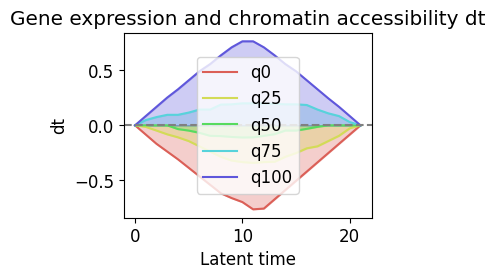

In [41]:
fig, ax = plt.subplots(figsize=(3.2, 2.4))
for i, qt in enumerate([0, .25, .5, .75, 1.]):
    plt.stackplot(range(22), np.quantile(time_lag_c_s_mv_, qt, axis=0), 
                  color=sns.color_palette('hls', 6)[i], alpha=.3)
for i, qt in enumerate([0, .25, .5, .75, 1.]):
    plt.plot(range(22), np.quantile(time_lag_c_s_mv_, qt, axis=0), 
             color=sns.color_palette('hls',6)[i], label=f'q{int(qt*100)}')
    
plt.legend()
plt.axhline(0, ls='--', color='grey')

ax.set_xlabel('Latent time')
ax.set_ylabel('dt')
ax.set_title('Gene expression and chromatin accessibility dt')
fig.savefig('../figures/fig7B_S.pdf')

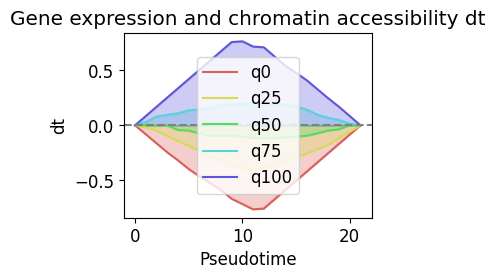

In [42]:
fig, ax = plt.subplots(figsize=(3.2, 2.4))
for i, qt in enumerate([0, .25, .5, .75, 1.]):
    plt.stackplot(range(22), np.quantile(time_lag_c_s_mf_, qt, axis=0), 
                  color=sns.color_palette('hls', 6)[i], alpha=.3)
for i, qt in enumerate([0, .25, .5, .75, 1.]):
    plt.plot(range(22), np.quantile(time_lag_c_s_mf_, qt, axis=0), 
             color=sns.color_palette('hls',6)[i], label=f'q{int(qt*100)}')
plt.axhline(0, ls='--', color='grey')
plt.legend()
ax.set_xlabel('Pseudotime')
ax.set_ylabel('dt')
ax.set_title('Gene expression and chromatin accessibility dt')
fig.savefig('../figures/fig7B.pdf')

In [23]:
from sklearn.metrics import pairwise
from sklearn.cluster import AgglomerativeClustering
n_cluster=6


In [24]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, linkage='average')
cluster_labels = cluster.fit_predict(time_lag_c_s_mf_)

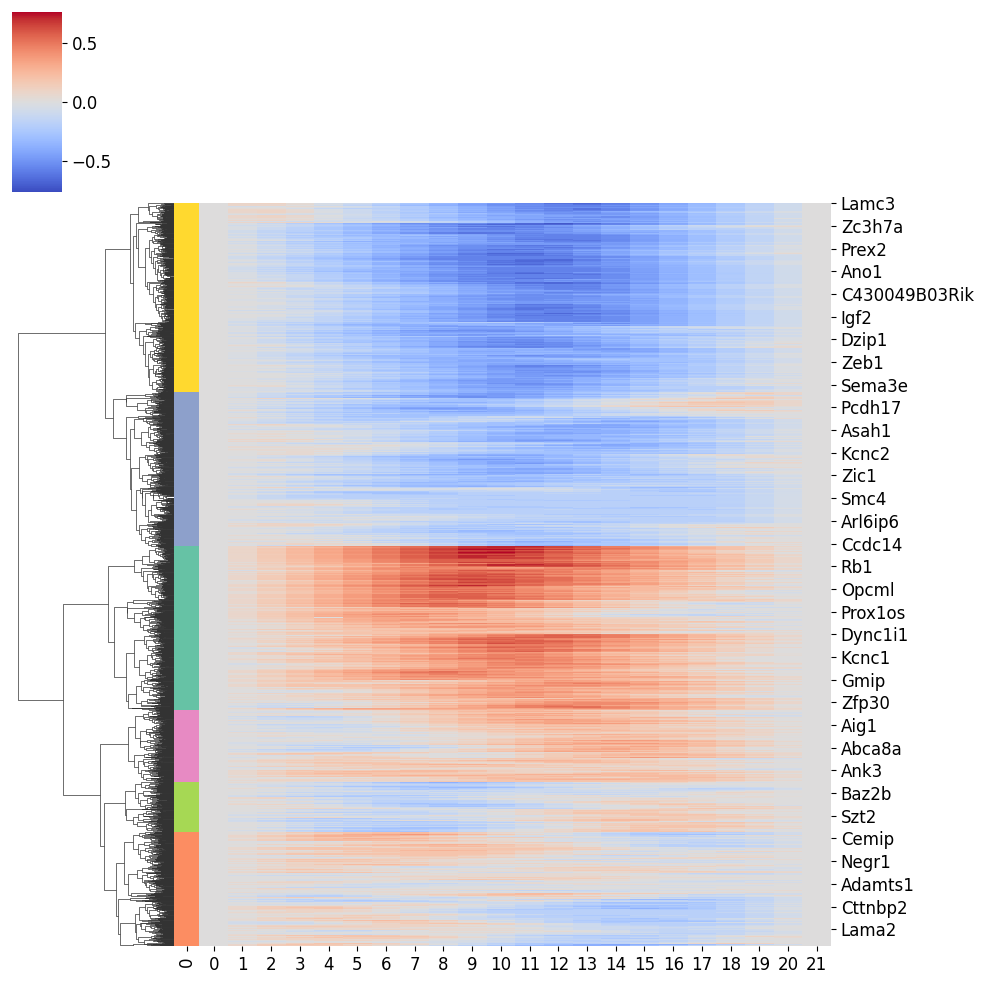

In [25]:
sns.clustermap(time_lag_c_s_mf_, cmap='coolwarm', col_cluster=False,
               row_colors=pd.DataFrame(cluster_labels, index=time_lag_c_s_mf_.index)[0].map(
    dict(zip(range(6), sns.color_palette("Set2", n_cluster)))))

In [26]:
time_lag_c_s_mf_n = time_lag_c_s_mf_.loc[(cluster_labels==2)|(cluster_labels==5)]

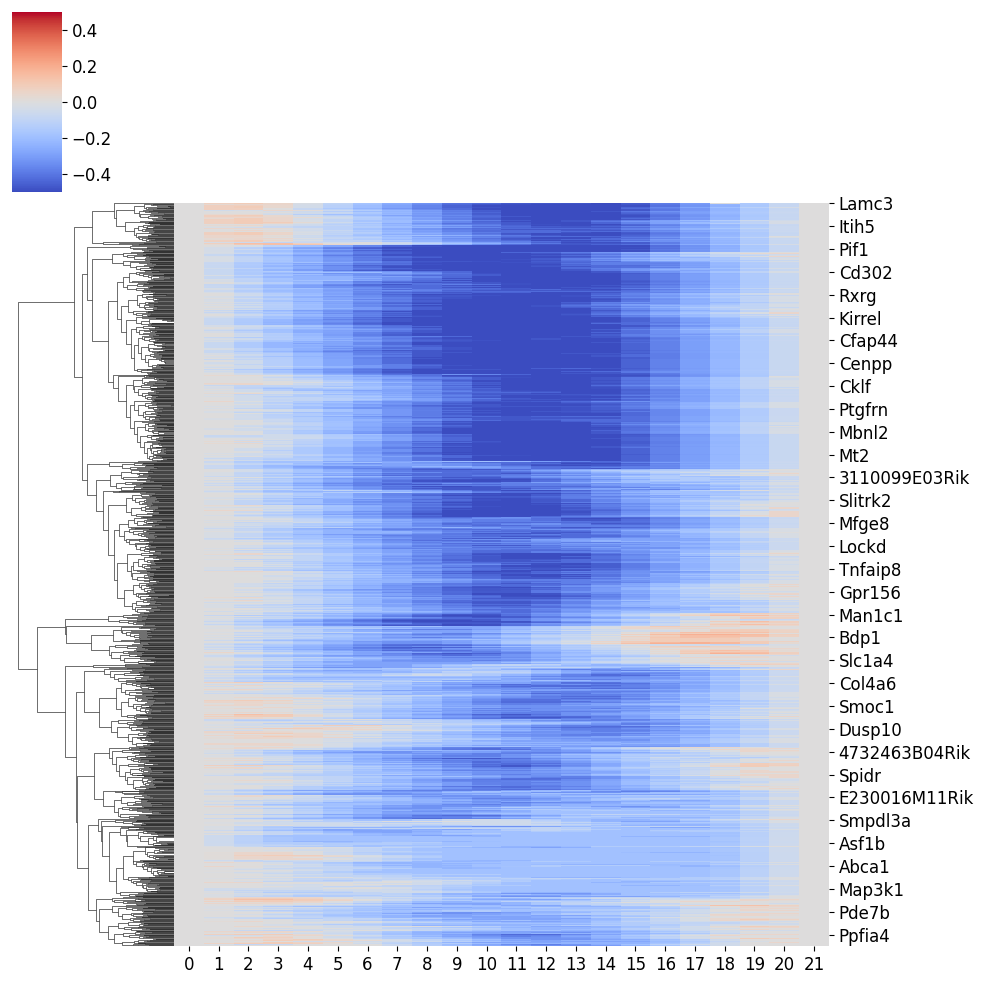

In [27]:
sns.clustermap(time_lag_c_s_mf_n, cmap='coolwarm', col_cluster=False,
               vmax=.5, vmin=-.5
)

In [28]:
time_lag_c_s_mf_n['labels'] = labels.loc[time_lag_c_s_mf_n.index]

In [29]:
time_lag_c_s_mf_n['labels']

1110015O18Rik     1
1500004A13Rik     8
2410006H16Rik     5
2610037D02Rik     9
2610316D01Rik     1
                 ..
Zic5              1
Znrf3             1
Zranb2           10
Zscan26           3
Zzz3              3
Name: labels, Length: 1301, dtype: int64

In [30]:
clustercount = labels.reset_index().pivot_table(index='label', values='Gene', aggfunc='count')
clustercount_n = labels.loc[time_lag_c_s_mf_n.index].reset_index().pivot_table(index='label', values='index', aggfunc='count')

In [31]:
cluster_prop = pd.DataFrame((clustercount_n.values/clustercount.values).ravel(),
index=range(12))

In [32]:
cluster_prop

,0
0,0.794118
1,0.657358
2,0.829630
3,0.394068
4,0.224490
5,0.119048
6,0.028986
7,0.074766
8,0.161094
9,0.144000


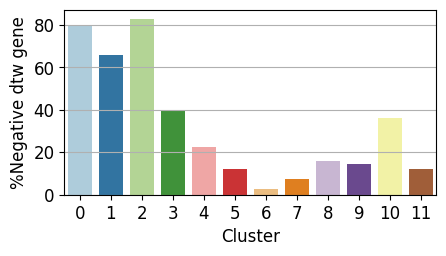

In [66]:
fig, ax= plt.subplots(figsize=(4.8, 2.4))
sns.barplot(cluster_prop.reset_index(), x='index', y=0, palette='Paired')
ax.set_ylabel('%Negative dtw gene')
ax.set_xlabel('Cluster')
ax.set_yticklabels([0, 20, 40, 60, 80])
ax.grid(axis='y')
fig.savefig('../figures/fig7C_count.pdf')

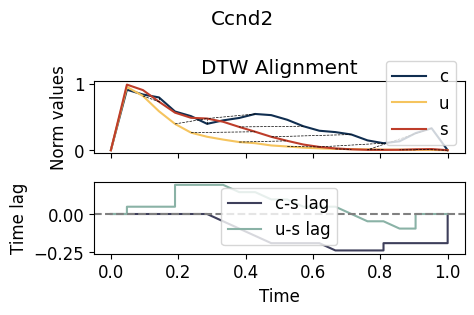

In [33]:
gene='Ccnd2'
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, gene, timekey='velo_s_norm_pseudotime')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig7D_ccnd2.pdf')


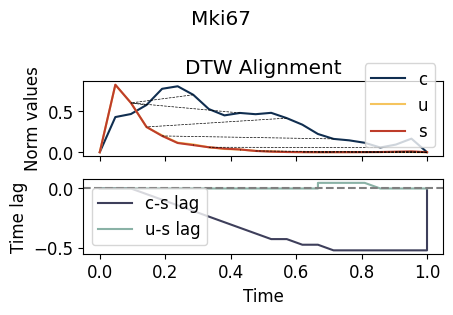

In [34]:
gene='Mki67'
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, gene, timekey='velo_s_norm_pseudotime')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig7D_mki67.pdf')


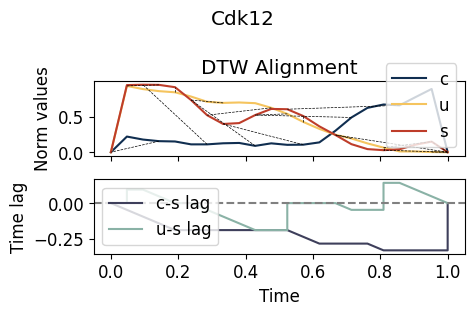

In [35]:
gene='Cdk12'
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, gene, timekey='velo_s_norm_pseudotime')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig7D_cdk12.pdf')

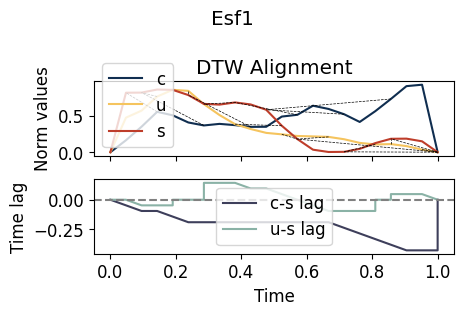

In [36]:
gene='Esf1'
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, gene, timekey='velo_s_norm_pseudotime')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig7D_esf1.pdf')

In [33]:
subcellhl_1 = pd.read_excel('../temps/subcellhl_table1.xlsx',
                            sheet_name='3T3_rates_rep1')
subcellhl_2 = pd.read_excel('../temps/subcellhl_table1.xlsx',
                            sheet_name='3T3_rates_rep2')

In [34]:
subcellhl_1 = subcellhl_1.set_index('Symbol')
subcellhl_2 = subcellhl_2.set_index('Symbol')

In [35]:
target = ['half_life_chr.Mean', 'half_life_chr.MAP',
       'half_life_chr.0.025.quantile', 'half_life_chr.0.975.quantile',
       'half_life_nuc.Mean', 'half_life_nuc.MAP',
       'half_life_nuc.0.025.quantile', 'half_life_nuc.0.975.quantile',
       'half_life_nucexp_from_nucres.Mean', 'half_life_nucexp_from_nucres.MAP',
       'half_life_nucexp_from_nucres.0.025.quantile',
       'half_life_nucexp_from_nucres.0.975.quantile',
       'half_life_nucexp_from_dist.Mean', 'half_life_nucexp_from_dist.MAP',
       'half_life_nucexp_from_dist.0.025.quantile',
       'half_life_nucexp_from_dist.0.975.quantile', 'half_life_cyto.Mean',
       'half_life_cyto.MAP', 'half_life_cyto.0.025.quantile',
       'half_life_cyto.0.975.quantile', 'half_life_poly_entry.Mean',
       'half_life_poly_entry.MAP', 'half_life_poly_entry.0.025.quantile',
       'half_life_poly_entry.0.975.quantile', 'half_life_whole_cell.Mean',
       'half_life_whole_cell.MAP', 'half_life_whole_cell.0.025.quantile',
       'half_life_whole_cell.0.975.quantile', 'half_life_nucdeg.MAP',
       'half_life_nucdeg.0.025.quantile', 'half_life_nucdeg.0.975.quantile',
       'half_life_nucexp_from_nucdeg.MAP',
       'half_life_nucexp_from_nucdeg.0.025.quantile',
       'half_life_nucexp_from_nucdeg.0.975.quantile',
       'half_life_chr_release_from_nucdeg.MAP',
       'half_life_chr_release_from_nucdeg.0.025.quantile',
       'half_life_chr_release_from_nucdeg.0.975.quantile']

In [36]:
subcellhl_ = (subcellhl_2.loc[:, target].values + subcellhl_1.loc[:, target].values)/2
subcellhl_ = pd.DataFrame(subcellhl_, index=subcellhl_1.index, columns=target)
subcellhl_['PUND'] = subcellhl_1['PUND']
subcellhl_ = subcellhl_[subcellhl_.index.isin(adata_out.var_names)].dropna()
PUND = subcellhl_[subcellhl_['PUND']==1].index



In [37]:
subcellhl_['label'] = labels.loc[subcellhl_.index]['label']

In [38]:
subcell_pivot = subcellhl_.pivot_table(index='label', 
                       values=['half_life_nuc.MAP', 'half_life_cyto.MAP',
                               'half_life_nucexp_from_nucdeg.MAP',
                               'half_life_nucexp_from_dist.MAP',])

In [39]:
subcellhl_['label2'] = ['other' if l in [4, 5, 6, 7, 8,9,11] else l for l in subcellhl_['label']]


In [40]:
subcellhl_

,half_life_chr.Mean,half_life_chr.MAP,half_life_chr.0.025.quantile,half_life_chr.0.975.quantile,half_life_nuc.Mean,half_life_nuc.MAP,half_life_nuc.0.025.quantile,half_life_nuc.0.975.quantile,half_life_nucexp_from_nucres.Mean,half_life_nucexp_from_nucres.MAP,...,half_life_nucdeg.0.975.quantile,half_life_nucexp_from_nucdeg.MAP,half_life_nucexp_from_nucdeg.0.025.quantile,half_life_nucexp_from_nucdeg.0.975.quantile,half_life_chr_release_from_nucdeg.MAP,half_life_chr_release_from_nucdeg.0.025.quantile,half_life_chr_release_from_nucdeg.0.975.quantile,PUND,label,label2
Symbol,,,,,,,,,,,,,,,,,,,,,
Cdc45,90.0,90.0,82.0,98.0,115.0,115.0,100.0,130.0,43.00,45.50,...,6900.0,19.75,11.05,25.00,100.0,81.0,118.0,0.0,0,0
Klf6,12.0,12.0,11.0,12.5,16.0,16.0,14.5,17.0,7.35,7.95,...,6350.0,3.10,1.95,4.50,12.0,10.0,15.0,0.0,9,other
Axin2,22.0,23.0,15.0,35.0,59.5,67.0,33.5,132.0,41.00,53.00,...,465.5,3465.50,7.95,770.00,5800.0,4800.0,6900.0,0.0,1,1
Ccnd2,74.0,109.5,96.0,112.0,130.0,130.0,125.0,140.0,44.00,47.00,...,6900.0,5.95,3.75,8.45,118.0,100.0,145.0,0.0,0,0
Mid2,85.5,87.0,71.0,104.5,111.0,112.0,82.0,150.0,46.00,57.00,...,5300.0,15.25,4.95,26.50,88.0,67.5,375.0,0.0,8,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rnaset2a,385.0,390.0,305.0,505.0,810.0,815.0,605.0,1165.0,418.00,500.00,...,5850.0,377.50,216.70,1665.50,3570.0,315.0,3075.0,0.0,1,1
Syne1,185.0,175.0,165.0,200.0,145.0,150.0,135.0,160.0,15.50,17.50,...,220.0,4.95,1.70,7.45,6900.0,760.0,6900.0,1.0,9,other
Zfp994,17.5,17.5,14.5,21.5,25.5,26.0,21.0,32.0,16.00,17.50,...,3300.0,22.00,14.00,26.00,18.0,13.5,28.5,0.0,1,1


In [41]:
palette= ['grey']+sns.color_palette('Paired')[:4] + [sns.color_palette('Paired')[10]]

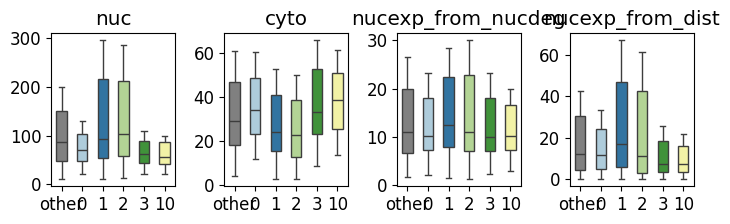

In [47]:
fig, axes = plt.subplots(1,4, figsize=(7.2, 2.4))
for i, y in enumerate(['half_life_nuc.MAP', 'half_life_cyto.MAP',
          'half_life_nucexp_from_nucdeg.MAP',
                               'half_life_nucexp_from_dist.MAP']):
    ax = axes[i]
    sns.boxplot(subcellhl_, x='label2', y=y, showfliers=False, 
            order=['other', 0, 1, 2, 3, 10],
            palette=palette,
            width=.5, whis=.5, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(y.strip('.MAP').strip('half_life_'))
fig.tight_layout()
fig.savefig('../figures/fig7F_box.pdf')

In [42]:
import scipy

<Axes: xlabel='label'>

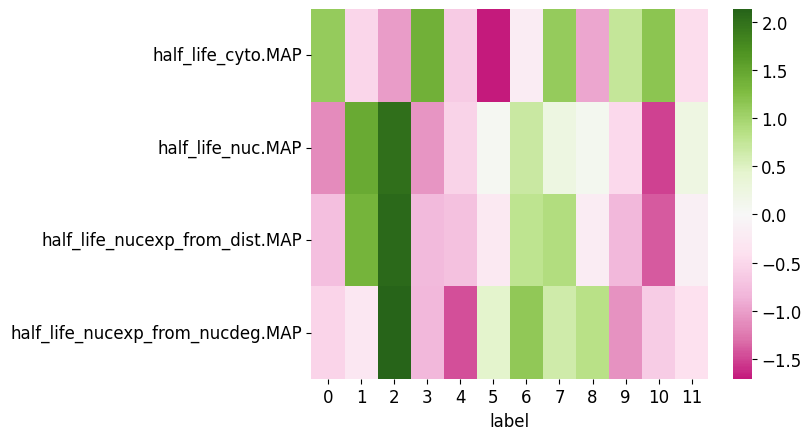

In [44]:
sns.heatmap(scipy.stats.zscore(subcell_pivot, axis=0).T,
            cmap='PiYG', center=0)

In [45]:
from scipy import stats

In [46]:
def ttestind_label(hl, label, alternative='greater'):
    target = subcellhl_[hl]
    target = target - np.min(target)
    target = target/np.max(target)
    
    a = target[subcellhl_['label'].isin(label)]
    b =  target[~subcellhl_['label'].isin(label)]
    print('target show greater', stats.ks_2samp(a, b,
                alternative='greater'))
    print('target show less', stats.ks_2samp(a, b,
                alternative='less'))
    print( 
    )
ttestind_label('half_life_chr.MAP', [0, 1, 2,3])
ttestind_label('half_life_nuc.MAP', [0, 1, 2,3])
ttestind_label('half_life_cyto.MAP', [0, 1, 2,3])
ttestind_label('half_life_nucexp_from_nucdeg.MAP', [0, 1, 2,3])
ttestind_label('half_life_nucexp_from_dist.MAP', [0, 1, 2,3])

target show greater KstestResult(statistic=0.012882701615095981, pvalue=0.8823267585996113, statistic_location=0.004490014743331993, statistic_sign=1)
target show less KstestResult(statistic=0.0686769264234053, pvalue=0.036948493512104774, statistic_location=0.15560916767189384, statistic_sign=-1)

target show greater KstestResult(statistic=0.008467018326173257, pvalue=0.9449607573032569, statistic_location=0.011351543100390209, statistic_sign=1)
target show less KstestResult(statistic=0.08192035093443543, pvalue=0.009287102421711404, statistic_location=0.19829726853494148, statistic_sign=-1)

target show greater KstestResult(statistic=0.08656261895698515, pvalue=0.005406316023369889, statistic_location=0.06512605042016807, statistic_sign=1)
target show less KstestResult(statistic=0.01756666122863306, pvalue=0.7967580435426698, statistic_location=0.2273576097105509, statistic_sign=-1)

target show greater KstestResult(statistic=0.00870810448275237, pvalue=0.9420798543398672, statistic_

In [53]:
ttestind_label('half_life_chr.MAP', [10])
ttestind_label('half_life_nuc.MAP', [10])
ttestind_label('half_life_cyto.MAP', [10])
ttestind_label('half_life_nucexp_from_nucdeg.MAP', [10])
ttestind_label('half_life_nucexp_from_dist.MAP', [10])

target show greater KstestResult(statistic=0.2277369063273744, pvalue=1.4294824457911427e-05, statistic_location=0.058102131081624445, statistic_sign=1)
target show less KstestResult(statistic=0.006545355463150537, pvalue=0.9868285153083597, statistic_location=0.004490014743331993, statistic_sign=-1)

target show greater KstestResult(statistic=0.2391216784542299, pvalue=4.532812592098857e-06, statistic_location=0.05427456544874069, statistic_sign=1)
target show less KstestResult(statistic=0.010040160642570281, pvalue=0.9718673273729379, statistic_location=0.0046115643845335225, statistic_sign=-1)

target show greater KstestResult(statistic=0.009370816599732263, pvalue=0.9748480408947671, statistic_location=0.41643323996265175, statistic_sign=1)
target show less KstestResult(statistic=0.22535570008648162, pvalue=1.804209313329285e-05, statistic_location=0.046451914098972924, statistic_sign=-1)

target show greater KstestResult(statistic=0.12006136640959117, pvalue=0.04431247259497875, s

In [47]:
def ttestind_label(hl, label, alternative='greater'):
    target = subcellhl_[hl]
    target = target - np.min(target)
    target = target/np.max(target)
    
    a = target[subcellhl_['label'].isin(label)]
    b =  target[~subcellhl_['label'].isin(label)]
    
    great = stats.ks_2samp(b, a,
                alternative='greater')
    print(great)
    less = stats.ks_2samp(b, a,
                alternative='less')
    print(less)
    return great[1], less[1]

pvalues_g = []
pvalues_l = []
for i in range(12):
    pvalue_g = []
    pvalue_l = []
    for hl in ['half_life_nuc.MAP',
               'half_life_cyto.MAP',
               'half_life_nucexp_from_nucdeg.MAP',
               'half_life_nucexp_from_dist.MAP',
               ]:
        g, l = ttestind_label(hl, [i])
        pvalue_g.append(g)
        pvalue_l.append(l)
    pvalues_g.append(pvalue_g)
    pvalues_l.append(pvalue_l)

KstestResult(statistic=0.01496792587312901, pvalue=0.9132544264243416, statistic_location=0.005321035828307911, statistic_sign=1)
KstestResult(statistic=0.17387111651503082, pvalue=1.7559075717911815e-05, statistic_location=0.09187655196878326, statistic_sign=-1)
KstestResult(statistic=0.17256439282769415, pvalue=2.069429103590376e-05, statistic_location=0.0546218487394958, statistic_sign=1)
KstestResult(statistic=0.005076656464438947, pvalue=0.9865780799358513, statistic_location=0.4047619047619048, statistic_sign=-1)
KstestResult(statistic=0.0490510530655598, pvalue=0.4094281765193446, statistic_location=0.0007030106248822276, statistic_sign=1)
KstestResult(statistic=0.07893449610778025, pvalue=0.10246967182293003, statistic_location=0.001224832944382438, statistic_sign=-1)
KstestResult(statistic=0.02377258815144019, pvalue=0.8032818913433432, statistic_location=0.008062414097691609, statistic_sign=1)
KstestResult(statistic=0.12460344080611574, pvalue=0.003576163536103326, statistic_

In [48]:
colname = ['half_life_nuc.MAP',
               'half_life_cyto.MAP',
               'half_life_nucexp_from_nucdeg.MAP',
               'half_life_nucexp_from_dist.MAP',
               ]

In [49]:
pvalues_g_ = pd.DataFrame(pvalues_g, columns=[c+'_greater' for c in colname])
pvalues_l_ = pd.DataFrame(pvalues_l, columns=[c+'_less' for c in colname])

In [50]:
pd.concat([pvalues_g_, pvalues_l_], axis=1)

,half_life_nuc.MAP_greater,half_life_cyto.MAP_greater,half_life_nucexp_from_nucdeg.MAP_greater,half_life_nucexp_from_dist.MAP_greater,half_life_nuc.MAP_less,half_life_cyto.MAP_less,half_life_nucexp_from_nucdeg.MAP_less,half_life_nucexp_from_dist.MAP_less
0,9.132544e-01,0.000021,0.409428,8.032819e-01,1.755908e-05,9.865781e-01,0.102470,0.003576
1,4.677016e-09,0.952877,0.000889,1.787279e-07,9.896802e-01,6.793461e-09,0.975735,1.000000
2,1.567112e-03,0.975502,0.458886,1.051833e-01,8.072746e-01,1.512693e-04,0.735668,0.326507
3,9.982894e-01,0.000059,0.981038,9.663782e-01,2.012593e-08,9.833776e-01,0.094631,0.000010
4,3.917600e-01,0.541163,0.643198,3.746454e-01,5.229904e-01,4.158351e-01,0.519323,0.267014
5,4.226058e-01,0.946166,0.918320,4.953919e-01,4.201392e-01,2.176430e-02,0.013122,0.772507
6,3.600056e-02,0.207576,0.879108,7.933939e-01,8.783495e-01,6.302855e-01,0.102482,0.765208
7,1.019347e-01,0.099697,0.005722,6.278951e-02,5.707985e-01,6.953155e-01,0.855281,0.916427
8,7.820221e-01,0.870207,0.801076,9.707858e-01,4.360895e-01,1.311081e-01,0.173684,0.247793
9,9.337608e-01,0.008508,0.644126,1.000000e+00,3.110370e-01,9.420939e-01,0.611475,0.048368


In [61]:
df = pd.concat([pvalues_g_, pvalues_l_], axis=1).T.sort_index().T

In [67]:
text

2.069429103590376e-05

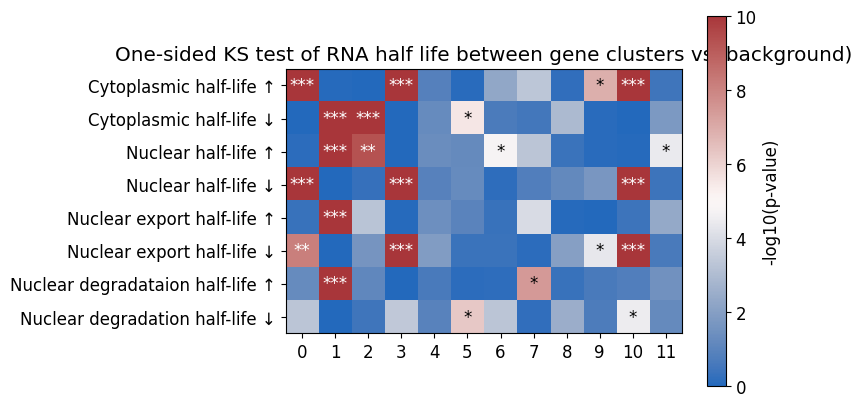

In [80]:
fig, ax = plt.subplots()
im = ax.imshow(-np.log2(df.T), vmax=10, cmap='vlag')
ax.set_xticks(range(12), labels=range(12),
              )
ax.set_yticks(range(8), ['Cytoplasmic half-life ↑', 'Cytoplasmic half-life ↓', 'Nuclear half-life ↑', 'Nuclear half-life ↓',
                         'Nuclear export half-life ↑', 'Nuclear export half-life ↓',
                         'Nuclear degradataion half-life ↑', 'Nuclear degradation half-life ↓']
              
)
plt.title('One-sided KS test of RNA half life between gene clusters vs. background)')
for i in range(8):
    for j in range(12):
        text = df.T.iloc[i, j]
        if text<=0.001:
            ax.text(j, i, '***',
                       ha="center", va="center", color="w")
        elif text<=0.005:
            ax.text(j, i, '**',
                       ha="center", va="center", color="w")
        elif text<=0.05:
            ax.text(j, i, '*',
                       ha="center", va="center", color="black")
plt.colorbar(im, label='-log10(p-value)')
fig.savefig('../figures/fig7E_heat.pdf')

ValueError: Could not interpret value `lagminus` for `x`. An entry with this name does not appear in `data`.

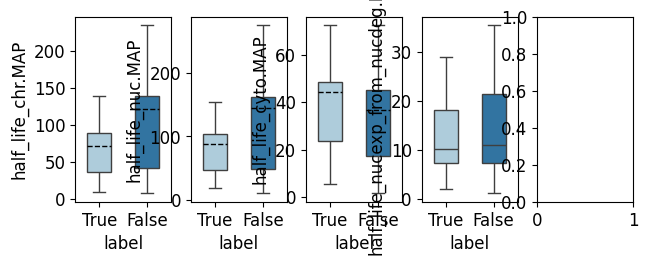

In [60]:
def get_hl(x, order=None):
    fig, axes = plt.subplots(1,5, figsize=(7.2, 2.4))
    sns.boxplot(subcellhl_, y='half_life_chr.MAP', x=x, palette='Paired',
            showfliers=False, width=.5, whis=1, order=order, ax=axes[0],
            meanline=True, showmeans=True, meanprops=dict(color='black'), medianprops=dict(linewidth=0),)
    sns.boxplot(subcellhl_, y='half_life_nuc.MAP', x=x, palette='Paired',
            showfliers=False, width=.5, whis=1, order=order, ax=axes[1],
            meanline=True, showmeans=True, meanprops=dict(color='black'), medianprops=dict(linewidth=0),)
    sns.boxplot(subcellhl_, y='half_life_cyto.MAP', x=x, palette='Paired',
            showfliers=False, width=.5, whis=1, order=order, ax=axes[2],
            meanline=True, showmeans=True, meanprops=dict(color='black'), medianprops=dict(linewidth=0),)
    sns.boxplot(subcellhl_, y='half_life_nucexp_from_nucdeg.MAP', x=x, palette='Paired',
            showfliers=False, width=.5, whis=1, order=order, ax=axes[3],
    )
    sns.boxplot(subcellhl_, y='half_life_nucexp_from_dist.MAP', x='lagminus', palette='Paired',
            showfliers=False, width=.5, whis=1, order=order, ax=axes[4],
    )
    
    fig.tight_layout()
get_hl(subcellhl_['label'].isin([0]), order=[True, False])

ValueError: Could not interpret value `lagminus` for `x`. An entry with this name does not appear in `data`.

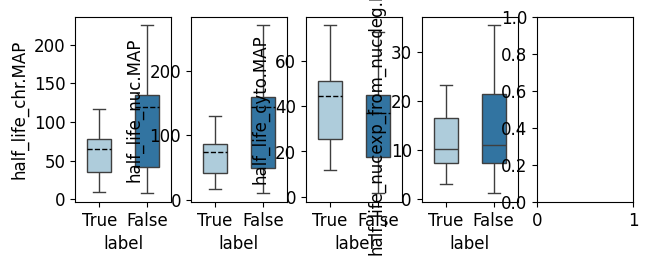

In [61]:
get_hl(subcellhl_['label'].isin([10]), order=[True, False])

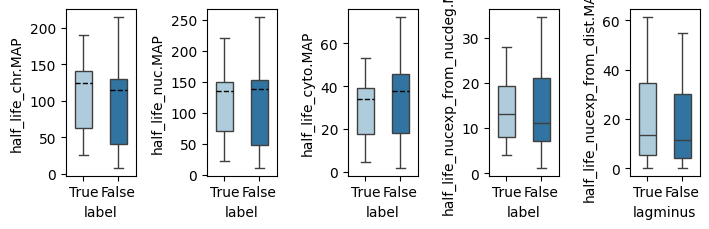

In [263]:
get_hl(subcellhl_['label'].isin([11]), order=[True, False])

In [85]:
hek_speckle = pd.read_excel('../temps/slam-rt_tag_table1.xlsx',
                   sheet_name='HEK293T_SC35',
                   header=0)
k562_speckle = pd.read_excel('../temps/slam-rt_tag_table1.xlsx',
                   sheet_name='K562_SC35',
                   header=0)

In [86]:
hek_polycomb = pd.read_excel('../temps/slam-rt_tag_table1.xlsx',
                   sheet_name='HEK293T_H3K27me3',
                   header=1)
k562_polycomb = pd.read_excel('../temps/slam-rt_tag_table1.xlsx',
                   sheet_name='K562_H3K27me3',
                   header=0)

In [87]:
hek_speckle

,chromosome,start,end,width,strand,source,gene_id,gene_type,gene_name,IgG n1,SC35 n1,IgG n2,SC35 n2,IgG n3,SC35 n3,Results_log2,Results_pvalue,diffexpressed
0,chr1,14363,29806,15444,-,HAVANA,ENSG00000227232.4,pseudogene,WASH7P,0.000000,1.839336,0.000000,6.491934,0.000000,7.873737,5.033245,0.169702,NO
1,chr1,134901,139379,4479,-,ENSEMBL,ENSG00000237683.5,protein_coding,AL627309.1,0.000000,0.000000,0.000000,1.081989,0.000000,0.000000,1.457859,NaN,NO
2,chr1,227615,267253,39639,-,HAVANA,ENSG00000228463.4,lincRNA,AP006222.2,0.000000,5.518009,0.000000,0.000000,0.000000,0.000000,1.873722,NaN,NO
3,chr1,317720,453948,136229,+,HAVANA,ENSG00000237094.7,lincRNA,RP4-669L17.10,0.000000,0.000000,0.000000,1.081989,0.000000,0.000000,1.457859,NaN,NO
4,chr1,564442,564813,372,+,HAVANA,ENSG00000225972.1,pseudogene,MTND1P23,1.671518,0.000000,0.000000,0.000000,3.628431,8.748597,-0.240172,NaN,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25262,chrY,5075256,5076110,855,-,HAVANA,ENSG00000231341.1,pseudogene,VDAC1P6,0.000000,0.000000,0.000000,0.000000,2.177059,0.000000,-0.780356,NaN,NO
25263,chrY,5205786,5207005,1220,-,HAVANA,ENSG00000235001.2,pseudogene,EIF4A1P2,4.178795,0.000000,0.000000,1.081989,4.354117,1.749719,-1.030986,NaN,NO
25264,chrY,15398518,15399258,741,+,HAVANA,ENSG00000215414.3,pseudogene,PSMA6P1,10.864866,11.036017,17.764310,12.983868,34.832937,20.121774,-0.430352,0.787930,NO
25265,chrY,21034387,21239302,204916,-,HAVANA,ENSG00000176728.3,lincRNA,TTTY14,0.000000,0.000000,0.000000,0.000000,0.725686,0.000000,-0.320858,NaN,NO


In [88]:
df_upcase = labels.copy()
df_upcase.index = np.char.upper(df_upcase.index.values.astype('str'))


In [89]:
hek_speckle = hek_speckle[hek_speckle['gene_name'].isin(df_upcase.index)]
k562_speckle = k562_speckle[k562_speckle['gene_name'].isin(df_upcase.index)]
hek_polycomb = hek_polycomb[hek_polycomb['gene_name'].isin(df_upcase.index)]
k562_polycomb = k562_polycomb[k562_polycomb['gene_name'].isin(df_upcase.index)]

In [90]:
hek_speckle_gene = hek_speckle[hek_speckle['diffexpressed']=='UP']['gene_name']
k562_speckle_gene = k562_speckle[k562_speckle['diffexpressed']=='UP']['gene_name']
speckle_gene = list(set(hek_speckle_gene)|set(k562_speckle_gene))
speckle_total_gene = list(set(hek_speckle['gene_name'])|set(k562_speckle))

In [91]:
hek_polycomb_gene = hek_polycomb[hek_polycomb['diffexpressed']=='UP']['gene_name']
k562_polycomb_gene = k562_polycomb[k562_polycomb['diffexpressed']=='UP']['gene_name']
polycomb_gene = list(set(hek_polycomb_gene)|set(k562_polycomb_gene))
polycomb_total_gene = list(set(hek_polycomb['gene_name'])|set(k562_polycomb))

In [92]:
from scipy.stats import fisher_exact


In [93]:
import matplotlib_venn

In [94]:
fishers = []
for name, geneset in zip(
    ['polycomb', 'speckle'],
    [[polycomb_gene, polycomb_total_gene], [speckle_gene, speckle_total_gene]]):
    
    total_target, total_gene = geneset
    total_nontarget = set(total_gene) - set(total_target)
    
    A = len(total_target)
    B = len(total_nontarget)
    
    fisher_ = []
    for i in range(12):
        temp = df_upcase[df_upcase['label']==i]
        
        a = len(set(total_target)&set(temp.index))
        b = len(set(total_nontarget)&set(temp.index))

        table = [[a, b],
                [A - a, B - b]]
        
        oddsratio, p_value = fisher_exact(table, alternative='greater')  # or 'two-sided'

        fisher_.append([oddsratio, p_value])
        
    fisher_ = pd.DataFrame(fisher_, index=range(12), columns=['oddsR', 'pval'])
    fisher_['data'] = name
    fishers.append(fisher_)

In [95]:
fishers =pd.concat(fishers)
fishers = fishers.reset_index(names=['label'])
pval = fishers.pivot_table(index='label', columns='data', values='pval')


TypeError: Colorbar.__init__() got an unexpected keyword argument 'line'

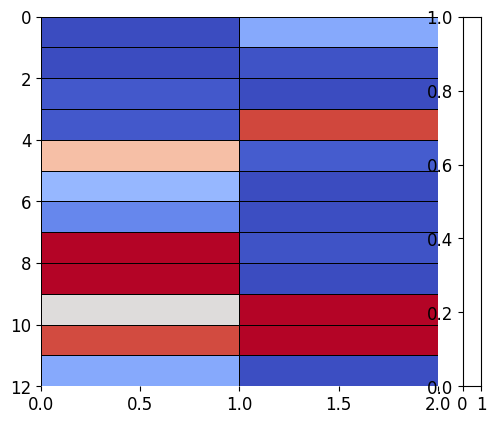

In [100]:
sns.heatmap(-np.log10(pval), vmax=3,  cmap='coolwarm',
            cbar_kws={'label': '-np.log10(p-val)','line': True}, linewidth=.5, linecolor='black')
plt.savefig('../figures/fig7G_heat.pdf')

In [74]:
subcellhl_

,half_life_chr.Mean,half_life_chr.MAP,half_life_chr.0.025.quantile,half_life_chr.0.975.quantile,half_life_nuc.Mean,half_life_nuc.MAP,half_life_nuc.0.025.quantile,half_life_nuc.0.975.quantile,half_life_nucexp_from_nucres.Mean,half_life_nucexp_from_nucres.MAP,...,half_life_nucdeg.0.975.quantile,half_life_nucexp_from_nucdeg.MAP,half_life_nucexp_from_nucdeg.0.025.quantile,half_life_nucexp_from_nucdeg.0.975.quantile,half_life_chr_release_from_nucdeg.MAP,half_life_chr_release_from_nucdeg.0.025.quantile,half_life_chr_release_from_nucdeg.0.975.quantile,PUND,label,label2
Symbol,,,,,,,,,,,,,,,,,,,,,
Cdc45,90.0,90.0,82.0,98.0,115.0,115.0,100.0,130.0,43.00,45.50,...,6900.0,19.75,11.05,25.00,100.0,81.0,118.0,0.0,0,0
Klf6,12.0,12.0,11.0,12.5,16.0,16.0,14.5,17.0,7.35,7.95,...,6350.0,3.10,1.95,4.50,12.0,10.0,15.0,0.0,9,other
Axin2,22.0,23.0,15.0,35.0,59.5,67.0,33.5,132.0,41.00,53.00,...,465.5,3465.50,7.95,770.00,5800.0,4800.0,6900.0,0.0,1,1
Ccnd2,74.0,109.5,96.0,112.0,130.0,130.0,125.0,140.0,44.00,47.00,...,6900.0,5.95,3.75,8.45,118.0,100.0,145.0,0.0,0,0
Mid2,85.5,87.0,71.0,104.5,111.0,112.0,82.0,150.0,46.00,57.00,...,5300.0,15.25,4.95,26.50,88.0,67.5,375.0,0.0,8,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rnaset2a,385.0,390.0,305.0,505.0,810.0,815.0,605.0,1165.0,418.00,500.00,...,5850.0,377.50,216.70,1665.50,3570.0,315.0,3075.0,0.0,1,1
Syne1,185.0,175.0,165.0,200.0,145.0,150.0,135.0,160.0,15.50,17.50,...,220.0,4.95,1.70,7.45,6900.0,760.0,6900.0,1.0,9,other
Zfp994,17.5,17.5,14.5,21.5,25.5,26.0,21.0,32.0,16.00,17.50,...,3300.0,22.00,14.00,26.00,18.0,13.5,28.5,0.0,1,1


In [75]:
labels_speckle = labels.loc[df_upcase.index.isin(speckle_gene)]
labels_polycomb = labels.loc[df_upcase.index.isin(polycomb_gene)]

In [76]:
time_lag_c_s_mf_n

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,labels
1110015O18Rik,0.0,-0.029478,-0.047619,-0.047619,-0.117914,-0.195011,-0.272109,-0.349206,-0.426304,-0.476190,...,-0.569161,-0.492063,-0.414966,-0.337868,-0.260771,-0.183673,-0.106576,-0.029478,0.0,1
1500004A13Rik,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.061224,-0.126984,-0.192744,-0.258503,...,-0.380952,-0.380952,-0.346939,-0.281179,-0.215420,-0.149660,-0.083900,-0.018141,0.0,8
2410006H16Rik,0.0,0.047619,0.047619,-0.006803,-0.072562,-0.138322,-0.142857,-0.174603,-0.240363,-0.285714,...,-0.285714,-0.285714,-0.285714,-0.281179,-0.238095,-0.197279,-0.131519,-0.065760,0.0,5
2610037D02Rik,0.0,0.000000,-0.045351,-0.068027,-0.138322,-0.208617,-0.278912,-0.349206,-0.380952,-0.367347,...,-0.133787,-0.063492,0.000000,0.000000,0.004535,0.074830,0.092971,0.047619,0.0,9
2610316D01Rik,0.0,-0.015873,-0.079365,-0.142857,-0.206349,-0.269841,-0.285714,-0.285714,-0.285714,-0.285714,...,-0.126984,-0.063492,-0.047619,-0.031746,0.031746,0.047619,0.031746,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zic5,0.0,0.000000,0.000000,-0.006803,-0.047619,-0.090703,-0.108844,-0.174603,-0.240363,-0.285714,...,-0.240363,-0.222222,-0.156463,-0.090703,-0.024943,0.040816,0.095238,0.065760,0.0,1
Znrf3,0.0,-0.024943,-0.095238,-0.095238,-0.099773,-0.172336,-0.238095,-0.269841,-0.342404,-0.414966,...,-0.523810,-0.460317,-0.387755,-0.315193,-0.242630,-0.170068,-0.097506,-0.024943,0.0,1
Zranb2,0.0,0.000000,-0.040816,-0.108844,-0.176871,-0.244898,-0.312925,-0.333333,-0.333333,-0.292517,...,-0.020408,0.047619,0.095238,0.095238,0.095238,0.095238,0.095238,0.068027,0.0,10
Zscan26,0.0,0.000000,0.000000,0.000000,0.000000,-0.031746,-0.095238,-0.142857,-0.174603,-0.190476,...,-0.301587,-0.333333,-0.333333,-0.317460,-0.253968,-0.190476,-0.126984,-0.063492,0.0,3


In [77]:
import matplotlib_venn

In [78]:
time_lag_c_s_mf_n['label'] = time_lag_c_s_mf_n['labels']

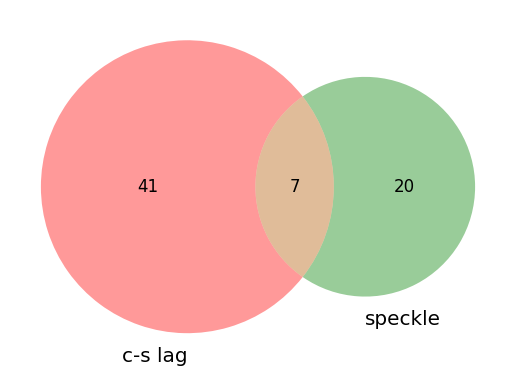

In [79]:
matplotlib_venn.venn2((set(time_lag_c_s_mf_n[time_lag_c_s_mf_n['label']==10].index),
                       set(labels_speckle[labels_speckle['label']==10].index)),
                      set_labels=['c-s lag', 'speckle'])

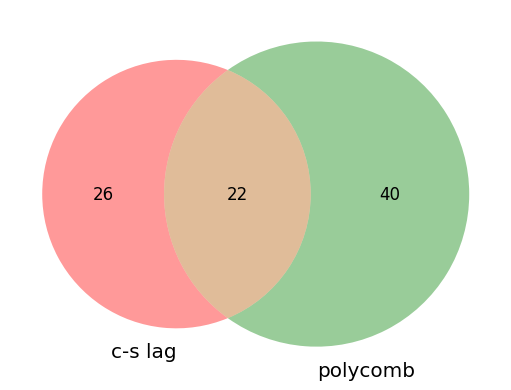

In [80]:
matplotlib_venn.venn2((set(time_lag_c_s_mf_n[time_lag_c_s_mf_n['label']==10].index),
                       set(labels_polycomb[labels_polycomb['label']==10].index)),
                      set_labels=['c-s lag', 'polycomb'])

In [225]:
target = subcellhl_[subcellhl_['label']==10]['half_life_nuc.MAP']
target = target - np.min(target)
target = target/np.max(target)
geneset = labels_speckle
a = target[target.index.isin(geneset.index)].values
b =  target[~target.index.isin(geneset.index)].values


In [228]:
a

array([0.14051282, 0.08410256, 0.03692308, 0.        , 0.06051282,
       0.07897436, 0.2       , 0.05333333, 0.24102564, 0.10153846,
       0.00923077, 0.1025641 , 0.05641026, 0.07282051, 0.02769231,
       0.04410256, 0.07487179, 0.03897436, 0.08820513, 0.05846154])

In [233]:
def ttestind_label(hl, label, geneset, alternative='greater'):
    target = subcellhl_[subcellhl_['label']==label][hl]
    target = target - np.min(target)
    target = target/np.max(target)
    
    a = target[target.index.isin(geneset.index)].values
    b =  target[~target.index.isin(geneset.index)].values
    print(len(a), len(b))
    print(f'target shows greater {hl}', stats.ttest_ind(a, b,
                equal_var=False, alternative='greater')[1])
    print(f'target show less {hl}', stats.ttest_ind(a, b,
                equal_var=False, alternative='less')[1])
    print( 
    )
ttestind_label('half_life_chr.MAP', 10, labels_speckle)
ttestind_label('half_life_nuc.MAP', 10, labels_speckle)
ttestind_label('half_life_cyto.MAP', 10, labels_speckle)
ttestind_label('half_life_nucexp_from_nucdeg.MAP', 10, labels_speckle)
ttestind_label('half_life_nucexp_from_dist.MAP', 10, labels_speckle)

20 93
target shows greater half_life_chr.MAP 0.9016789174619326
target show less half_life_chr.MAP 0.09832108253806732

20 93
target shows greater half_life_nuc.MAP 0.9915946880241276
target show less half_life_nuc.MAP 0.00840531197587235

20 93
target shows greater half_life_cyto.MAP 0.3469057560939136
target show less half_life_cyto.MAP 0.6530942439060863

20 93
target shows greater half_life_nucexp_from_nucdeg.MAP 0.8330248734757075
target show less half_life_nucexp_from_nucdeg.MAP 0.16697512652429242

20 93
target shows greater half_life_nucexp_from_dist.MAP 0.9990239662225119
target show less half_life_nucexp_from_dist.MAP 0.0009760337774880594



In [209]:
ttestind_label('half_life_chr.MAP', 10, labels_polycomb)
ttestind_label('half_life_nuc.MAP', 10, labels_polycomb)
ttestind_label('half_life_cyto.MAP', 10, labels_polycomb)
ttestind_label('half_life_nucexp_from_nucdeg.MAP', 10, labels_polycomb)
ttestind_label('half_life_nucexp_from_dist.MAP', 10, labels_polycomb)

target shows greater half_life_chr.MAP 0.9310158234316083
target show less half_life_chr.MAP 0.06898417656839166

target shows greater half_life_nuc.MAP 0.9120977040199079
target show less half_life_nuc.MAP 0.08790229598009211

target shows greater half_life_cyto.MAP 0.6090769926771287
target show less half_life_cyto.MAP 0.39092300732287133

target shows greater half_life_nucexp_from_nucdeg.MAP 0.1759944917998531
target show less half_life_nucexp_from_nucdeg.MAP 0.824005508200147

target shows greater half_life_nucexp_from_dist.MAP 0.7963349575338867
target show less half_life_nucexp_from_dist.MAP 0.20366504246611322

